### Modis Download and Processing
Script designed to process Modis images and save them one by one.

1. Find vtiles/htiles/dates for each data point
2. define windows around them, cut image
3. save images 

Potentially intended to offload eventually to azure vms

__________________________
Currently only compiled for train labels

In [32]:
import pandas as pd
import geojson as gsn
from pyproj import Proj
from osgeo import gdal
from osgeo import gdalconst

import tempfile
import wget
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import pickle
from collections import defaultdict
from datetime import datetime, timedelta

import xarray as xr
import rioxarray as rxr
from azure.storage.blob import ContainerClient

modis_account_name = 'modissa'
modis_container_name = 'modis-006'
modis_account_url = 'https://' + modis_account_name + '.blob.core.windows.net/'
modis_blob_root = modis_account_url + modis_container_name + '/'

# This file is provided by NASA; it indicates the lat/lon extents of each
# NOTE: this was from tutorial, not actually helpful because unprojected?

modis_tile_extents_url = modis_blob_root + 'sn_bound_10deg.txt'

temp_dir = os.path.join(tempfile.gettempdir(),'modis_snow')
os.makedirs(temp_dir,exist_ok=True)
fn = os.path.join(temp_dir,modis_tile_extents_url.split('/')[-1])
# wget.download(modis_tile_extents_url, fn)


modis_container_client = ContainerClient(account_url=modis_account_url, 
                                         container_name=modis_container_name,
                                                  credential=None)

#### Modis/azure helpers


In [33]:
def lat_lon_to_modis_tile(lat,lon):
    '''converts lat lon to modis tiles but reconstructing grid and its projection'''
    
    CELLS = 2400
    VERTICAL_TILES = 18
    HORIZONTAL_TILES = 36
    EARTH_RADIUS = 6371007.181
    EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

    TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
    TILE_HEIGHT = TILE_WIDTH
    CELL_SIZE = TILE_WIDTH / CELLS
    
    MODIS_GRID = Proj(f'+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext')
    
    x, y = MODIS_GRID(lon, lat)
    h = (EARTH_WIDTH * .5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * .25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT
    
    return int(h), int(v)


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files

In [84]:
file_root

['MYD10A1/08/05/2018116/MYD10A1.A2018116.h08v05.006.2018118031436.hdf']

In [64]:
def images_downloader(tiles, centroids, out_dataset, prod_name):
    """"""
    cell_ids = []
    i = 0
    for date_tile in tqdm(tiles.keys()):
        print("\n",i)

        date = date_tile[0]
        daynum = daynum_gen(date)   
        tile_num = (date_tile[1],date_tile[2])

        folder = prod_name + '/' + '{:0>2d}/{:0>2d}'.format(date_tile[1],date_tile[2]) + '/' + daynum


        # Find all HDF files from this tile on this day
        filenames = list_hdf_blobs_in_folder(modis_container_name,folder)
        print('Found {} matching file(s):'.format(len(filenames)))
        for fn in filenames:
            print(fn)
        file_root = filenames.copy()
        
        if len(file_root) > 1: #images may come in multiples
            print("multiple files found: ", len(file_root))
            blob_name1 = filenames[0]
            blob_name2 = filenames[1]
            
            # Download to a temporary file
            url1 = modis_blob_root + blob_name1
            url2 = modis_blob_root + blob_name2

            filename = os.path.join(temp_dir,blob_name1.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url1,filename)
                
            filename = os.path.join(temp_dir,blob_name2.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url2,filename)
            rds1 = rxr.open_rasterio(filename)
            rds2 = rxr.open_rasterio(filename)
            
            #find highest quality image
            rds1_quality = ((rds1.NDSI_Snow_Cover_Basic_QA.values >0) | (rds1.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()
            rds2_quality = ((rds2.NDSI_Snow_Cover_Basic_QA.values >0) | (rds2.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()
            
            rds = rds1 if rds1_quality >= rds2_quality else rds2 
                
        else:
            # Work with the first returned URL
            file_found = False
            breaker = 1
            while not file_found and breaker <= 5:
                try:
                    blob_name = filenames[0]
                    file_found = True
                except IndexError:
                    print("No file found: tile {} date {}".format(tile_num,daynum))
                    date -= timedelta(days=1)
                    daynum = daynum_gen(date) 

                    breaker +=1 
                    print("trying:", daynum)
            if breaker == 5:
                raise ValueError("Image", tile_num, daynum, "not found")


            # Download to a temporary file
            url = modis_blob_root + blob_name
            filename = os.path.join(temp_dir,blob_name.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url,filename)

            rds = rxr.open_rasterio(filename)

        #####reproject#####
        image = rds.rio.reproject(dst_crs="EPSG:4326")

#         #rewrite missing values for saving
#         image = image.where(image != 255, other = 32767) 

        for var in image.data_vars:
            image[var]=image[var].astype(image[var].dtype,keep_attrs = False) 

        #####create blocks around centroids#####    
        cells = tiles[date_tile]
        for cell in cells:
            center = centroids[cell]

            x_idx = np.nanargmin(np.abs(image.x.values - center[0]))
            y_idx = np.nanargmin(np.abs(image.y.values - center[1]))

            #subset 21x21 square
            xmin, xmax = x_idx -10 , x_idx + 11 
            ymin, ymax = y_idx -10 , y_idx + 11

            sub_image = image[dict(x= slice(xmin,xmax), y= slice(ymin,ymax))]

            out_dataset[i] = sub_image.squeeze().to_array().to_numpy()
            cell_ids.append((cell, daynum)) 

            i+=1
        
        
        
    return cell_ids, out_dataset


Ingest training + testing geodata and timestamps

Note: paths are currently absolute, but happy to make them work on both machines

In [34]:
path = "C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))

18130


Estimate centroids for lat_lon calculations by taking mean of points (not actual centroid because of projection and great circle distance?)

In [35]:
centroids = {} #cellid : centroid

for cell in range(len(gj['features'])):
    assert len(gj['features'][cell]['geometry']['coordinates'][0]) == 5 #coordinates have repeat on fifth, make sure this is universal
    
    cell_id =gj['features'][cell]['properties']['cell_id']
    centroid = list(np.mean(
        gj['features'][cell]['geometry']['coordinates'][0][0:4],
        axis = 0)) #lazy centroid calculation
    centroids[cell_id] = centroid

1. Ingest training, testing, submission datasets
2. Find what tiles (time, h,v) each image are stored in
3. store by cell_id, recall later for centroids

In [36]:
train_feat = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_train_features.csv")
test =pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_test_features.csv")
submission = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/submission_format.csv")
train_y = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/train_labels.csv")

In [37]:
#grab date/cell_id combos
dates = {}

#go through all rows, grab nonnull dates
for i in range(train_y.shape[0]):
    dates[train_y.iloc[i,0]] =list(
        train_y.iloc[i,1:][~train_y.iloc[i,:].isnull()].index)#cell_id : [dates]


Compile overlapping tiles

In [41]:
# create dictionary tiles (date, lat, lon) : [cell_ids]
counter = 0 
tiles = defaultdict(list)
for cell, date_list in tqdm(dates.items()):
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter += 1
print("total squares:", counter)    

  0%|          | 0/10878 [00:00<?, ?it/s]

total squares: 91490


## Download relevant images

Process and save smaller images one by one

Delete after cutting up larger image

In [42]:
# daynum = '2014236'
def daynum_gen(date_time):
    '''converts date time objects to filename'''
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

Load Terra images

In [65]:
product = 'MOD10A1' # Terra -morning
# product = 'MCD43A4'

#initialize empty array
dataset_t = np.empty((counter, 7, 21, 21)) #(image, band, row, column)
    
# download dataset
cell_ids, dataset_t = images_downloader(tiles, centroids, dataset_t, product)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImagesT.npy"
np.save(output_path,dataset_t)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_idsT.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)

  0%|          | 0/1120 [00:00<?, ?it/s]

0
Found 1 matching file(s):
MOD10A1/08/05/2018116/MOD10A1.A2018116.h08v05.006.2018118031402.hdf
1468
Found 1 matching file(s):
MOD10A1/08/05/2019075/MOD10A1.A2019075.h08v05.006.2019077031831.hdf
100% [..........................................................................] 7435898 / 74358982937
Found 1 matching file(s):
MOD10A1/08/05/2019108/MOD10A1.A2019108.h08v05.006.2019110033147.hdf
100% [..........................................................................] 6761155 / 67611554406
Found 1 matching file(s):
MOD10A1/08/05/2019118/MOD10A1.A2019118.h08v05.006.2019120033847.hdf
100% [..........................................................................] 6260344 / 62603445875
Found 1 matching file(s):
MOD10A1/08/05/2019159/MOD10A1.A2019159.h08v05.006.2019161025247.hdf
100% [..........................................................................] 5912183 / 59121836740
Found 1 matching file(s):
MOD10A1/09/05/2016094/MOD10A1.A2016094.h09v05.006.2016104070530.hdf
100% [.......

100% [..........................................................................] 1292976 / 129297633186
Found 1 matching file(s):
MOD10A1/08/04/2013057/MOD10A1.A2013057.h08v04.006.2016138235236.hdf
100% [..........................................................................] 1419882 / 141988233193
Found 1 matching file(s):
MOD10A1/08/04/2013064/MOD10A1.A2013064.h08v04.006.2016139184737.hdf
100% [..........................................................................] 1178288 / 117828833200
Found 1 matching file(s):
MOD10A1/08/04/2013071/MOD10A1.A2013071.h08v04.006.2016140144554.hdf
100% [..........................................................................] 1369111 / 136911133207
Found 1 matching file(s):
MOD10A1/08/04/2013078/MOD10A1.A2013078.h08v04.006.2016139210601.hdf
100% [..........................................................................] 1054381 / 105438133214
Found 1 matching file(s):
MOD10A1/08/04/2013085/MOD10A1.A2013085.h08v04.006.2016139195949.hdf
100% 

100% [..........................................................................] 1231678 / 123167833449
Found 1 matching file(s):
MOD10A1/08/04/2014133/MOD10A1.A2014133.h08v04.006.2016170160349.hdf
100% [..........................................................................] 1161901 / 116190133455
Found 1 matching file(s):
MOD10A1/08/04/2014140/MOD10A1.A2014140.h08v04.006.2016170044759.hdf
100% [..........................................................................] 1260346 / 126034633461
Found 1 matching file(s):
MOD10A1/08/04/2014147/MOD10A1.A2014147.h08v04.006.2016170050145.hdf
100% [..........................................................................] 1186692 / 118669233467
Found 1 matching file(s):
MOD10A1/08/04/2014154/MOD10A1.A2014154.h08v04.006.2016170033117.hdf
100% [..........................................................................] 1164448 / 116444833473
Found 1 matching file(s):
MOD10A1/08/04/2014161/MOD10A1.A2014161.h08v04.006.2016170071247.hdf
100% 

100% [..........................................................................] 1676311 / 167631133705
Found 1 matching file(s):
MOD10A1/08/04/2015356/MOD10A1.A2015356.h08v04.006.2016182005345.hdf
100% [..........................................................................] 1167380 / 116738033711
Found 1 matching file(s):
MOD10A1/08/04/2015363/MOD10A1.A2015363.h08v04.006.2016182175604.hdf
100% [..........................................................................] 1469177 / 146917733717
Found 1 matching file(s):
MOD10A1/08/04/2016005/MOD10A1.A2016005.h08v04.006.2016183130220.hdf
100% [............................................................................] 994040 / 99404033723
Found 1 matching file(s):
MOD10A1/08/04/2016012/MOD10A1.A2016012.h08v04.006.2016182220455.hdf
100% [............................................................................] 965367 / 96536733729
Found 1 matching file(s):
MOD10A1/08/04/2016019/MOD10A1.A2016019.h08v04.006.2016021070015.hdf
100% 

100% [..........................................................................] 1051394 / 105139433963
Found 1 matching file(s):
MOD10A1/08/04/2017115/MOD10A1.A2017115.h08v04.006.2017117025933.hdf
100% [............................................................................] 850764 / 85076433970
Found 1 matching file(s):
MOD10A1/08/04/2017122/MOD10A1.A2017122.h08v04.006.2017124031701.hdf
100% [..........................................................................] 1006481 / 100648133977
Found 1 matching file(s):
MOD10A1/08/04/2017129/MOD10A1.A2017129.h08v04.006.2017137214927.hdf
100% [..........................................................................] 1026818 / 102681833983
Found 1 matching file(s):
MOD10A1/08/04/2017136/MOD10A1.A2017136.h08v04.006.2017138030804.hdf
100% [............................................................................] 989955 / 98995533989
Found 1 matching file(s):
MOD10A1/08/04/2017143/MOD10A1.A2017143.h08v04.006.2017145031639.hdf
100% 

100% [..........................................................................] 1080010 / 108001034211
Found 1 matching file(s):
MOD10A1/08/04/2018345/MOD10A1.A2018345.h08v04.006.2018347025810.hdf
100% [..........................................................................] 1231625 / 123162534218
Found 1 matching file(s):
MOD10A1/08/04/2018352/MOD10A1.A2018352.h08v04.006.2018354030623.hdf
100% [..........................................................................] 1292997 / 129299734225
Found 1 matching file(s):
MOD10A1/08/04/2018359/MOD10A1.A2018359.h08v04.006.2018361030927.hdf
100% [..........................................................................] 1582122 / 158212234232
Found 1 matching file(s):
MOD10A1/08/04/2019001/MOD10A1.A2019001.h08v04.006.2019003030300.hdf
100% [..........................................................................] 1559239 / 155923934239
Found 1 matching file(s):
MOD10A1/08/04/2019008/MOD10A1.A2019008.h08v04.006.2019010184703.hdf
100% 

100% [..........................................................................] 7052036 / 705203639433
Found 1 matching file(s):
MOD10A1/08/05/2019107/MOD10A1.A2019107.h08v05.006.2019109032744.hdf
100% [..........................................................................] 7308922 / 730892240424
Found 1 matching file(s):
MOD10A1/08/05/2019123/MOD10A1.A2019123.h08v05.006.2019125234149.hdf
100% [..........................................................................] 6760058 / 676005841133
Found 1 matching file(s):
MOD10A1/08/05/2019164/MOD10A1.A2019164.h08v05.006.2019166033705.hdf
100% [..........................................................................] 6780467 / 678046741842
Found 1 matching file(s):
MOD10A1/09/05/2018089/MOD10A1.A2018089.h09v05.006.2018093185834.hdf
100% [..........................................................................] 8283763 / 828376342223
Found 1 matching file(s):
MOD10A1/09/05/2019098/MOD10A1.A2019098.h09v05.006.2019100033234.hdf
100% 

100% [..........................................................................] 7247465 / 724746547695
Found 1 matching file(s):
MOD10A1/08/05/2013344/MOD10A1.A2013344.h08v05.006.2016162135227.hdf
100% [..........................................................................] 8697448 / 869744847726
Found 1 matching file(s):
MOD10A1/08/05/2013351/MOD10A1.A2013351.h08v05.006.2016162113955.hdf
100% [..........................................................................] 7559785 / 755978547757
Found 1 matching file(s):
MOD10A1/08/05/2013358/MOD10A1.A2013358.h08v05.006.2016162141757.hdf
100% [..........................................................................] 7903921 / 790392147788
Found 1 matching file(s):
MOD10A1/08/05/2013365/MOD10A1.A2013365.h08v05.006.2016163023902.hdf
100% [..........................................................................] 7375539 / 737553947819
Found 1 matching file(s):
MOD10A1/08/05/2014007/MOD10A1.A2014007.h08v05.006.2016166213532.hdf
100% 

100% [..........................................................................] 6809191 / 680919148919
Found 1 matching file(s):
MOD10A1/08/05/2015055/MOD10A1.A2015055.h08v05.006.2016174011608.hdf
100% [..........................................................................] 7557071 / 755707148950
Found 1 matching file(s):
MOD10A1/08/05/2015062/MOD10A1.A2015062.h08v05.006.2016173234221.hdf
100% [..........................................................................] 8033965 / 803396548980
Found 1 matching file(s):
MOD10A1/08/05/2015069/MOD10A1.A2015069.h08v05.006.2016173140448.hdf
100% [..........................................................................] 7273067 / 727306749011
Found 1 matching file(s):
MOD10A1/08/05/2015076/MOD10A1.A2015076.h08v05.006.2016173140325.hdf
100% [..........................................................................] 7457459 / 745745949042
Found 1 matching file(s):
MOD10A1/08/05/2015083/MOD10A1.A2015083.h08v05.006.2016174163246.hdf
100% 

AssertionError: 

In [83]:
((image.NDSI_Snow_Cover_Basic_QA.values >0) | (image.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()

3793338

Load Aqua images

In [ ]:
product = 'MYD10A1' # Aqua -afternoon

#initialize empty array
dataset_a = np.empty((counter, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids, dataset_t = images_downloader(tiles, centroids, dataset_a, product)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImagesA.npy"
np.save(output_path,dataset_a)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_idsA.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)

### Sanity check if desired

In [51]:
def plot_image(image):
    image[image == image.max()] = image.max()/3
    image = image/image.max()
    r = image[12]; g = image[2]; b = image[1]
    
    plt.imshow(np.dstack([r,g,b]))

# plot_image(dataset[10001])

## Load and process submission images

In [8]:
#grab date/cell_id combos
dates_sub = {}

#go through all rows, grab nonnull dates_sub
for i in range(submission.shape[0]):
    dates_sub[submission.iloc[i,0]] =list(
        submission.iloc[i,1:][~submission.iloc[i,:].isnull()].index)#cell_id : [dates_sub]

In [9]:
# create dictionary tiles_sub (date, lat, lon) : [cell_ids]
counter_sub = 0 
tiles_sub = defaultdict(list)
for cell, date_list in tqdm(dates_sub.items()):
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles_sub[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter_sub += 1
print("total squares:", counter_sub)    

  0%|          | 0/9066 [00:00<?, ?it/s]

total squares: 516762


In [10]:
product = 'MOD10A1'

#initialize empty array
dataset_sub = np.empty((counter_sub, 14, 21, 21)) #(image, band, row, column)
cell_ids_sub = []

In [11]:
i = 0
for date_tile in tqdm(tiles_sub.keys()):
    print(i)
    
    date = date_tile[0]
    daynum = daynum_gen(date)   
    tile_num = (date_tile[1],date_tile[2])

    folder = product + '/' + '{:0>2d}/{:0>2d}'.format(date_tile[1],date_tile[2]) + '/' + daynum


    # Find all HDF files from this tile on this day
    filenames = list_hdf_blobs_in_folder(modis_container_name,folder)
    print('Found {} matching file(s):'.format(len(filenames)))
    for fn in filenames:
        print(fn)
    file_root = filenames.copy()
    assert len(file_root) == 1 # future images may come in multiples

    # Work with the first returned URL
    file_found = False
    breaker = 1
    while not file_found and breaker <= 5:
        try:
            blob_name = filenames[0]
            file_found = True
        except IndexError:
            print("No file found: tile {} date {}".format(tile_num,daynum))
            date -= timedelta(days=1)
            daynum = daynum_gen(date) 

            breaker +=1 
            print("trying:", daynum)
    if breaker == 5:
        raise ValueError("Image", tile_num, daynum, "not found")


    # Download to a temporary file
    url = modis_blob_root + blob_name

    filename = os.path.join(temp_dir,blob_name.replace('/','_'))
    if not os.path.isfile(filename):
        wget.download(url,filename)



    #####reproject#####
    rds = rxr.open_rasterio(filename)
    image = rds.rio.reproject(dst_crs="EPSG:4326")

    #rewrite missing values for saving
    image = image.where(image != 255, other = 32767) 

    for var in image.data_vars:
        image[var]=image[var].astype(image[var].dtype,keep_attrs = False) 

    #####create blocks around centroids#####    
    cells = tiles_sub[date_tile]
    for cell in cells:
        center = centroids[cell]

        x_idx = np.nanargmin(np.abs(image.x.values - center[0]))
        y_idx = np.nanargmin(np.abs(image.y.values - center[1]))

        #subset 21x21 square
        xmin, xmax = x_idx -10 , x_idx + 11 
        ymin, ymax = y_idx -10 , y_idx + 11

        sub_image = image[dict(x= slice(xmin,xmax), y= slice(ymin,ymax))]

        dataset_sub[i] = sub_image.squeeze().to_array().to_numpy()
        cell_ids_sub.append((cell, daynum)) 

        i+=1
    
#     os.remove(filename) #not removing right now

    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImages_sub.npy"
np.save(output_path,dataset_sub)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_sub.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids_sub, handle)

  0%|          | 0/285 [00:00<?, ?it/s]

0
Found 1 matching file(s):
MCD43A4/08/05/2020007/MCD43A4.A2020007.h08v05.006.2020016203410.hdf
6058
Found 1 matching file(s):
MCD43A4/08/05/2020014/MCD43A4.A2020014.h08v05.006.2020023034644.hdf
12116
Found 1 matching file(s):
MCD43A4/08/05/2020021/MCD43A4.A2020021.h08v05.006.2020030032006.hdf
18174
Found 1 matching file(s):
MCD43A4/08/05/2020028/MCD43A4.A2020028.h08v05.006.2020038222823.hdf
24232
Found 1 matching file(s):
MCD43A4/08/05/2020035/MCD43A4.A2020035.h08v05.006.2020044034111.hdf
30290
Found 1 matching file(s):
MCD43A4/08/05/2020042/MCD43A4.A2020042.h08v05.006.2020051032518.hdf
36348
Found 1 matching file(s):
MCD43A4/08/05/2020049/MCD43A4.A2020049.h08v05.006.2020058043935.hdf
42406
Found 1 matching file(s):
MCD43A4/08/05/2020056/MCD43A4.A2020056.h08v05.006.2020065031713.hdf
48464
Found 1 matching file(s):
MCD43A4/08/05/2020063/MCD43A4.A2020063.h08v05.006.2020072033944.hdf
54522
Found 1 matching file(s):
MCD43A4/08/05/2020070/MCD43A4.A2020070.h08v05.006.2020079034813.hdf
60580

416881
Found 1 matching file(s):
MCD43A4/09/05/2020182/MCD43A4.A2020182.h09v05.006.2020191030835.hdf
419744
Found 1 matching file(s):
MCD43A4/09/05/2020336/MCD43A4.A2020336.h09v05.006.2020347032229.hdf
422607
Found 1 matching file(s):
MCD43A4/09/05/2020343/MCD43A4.A2020343.h09v05.006.2020352030039.hdf
425470
Found 1 matching file(s):
MCD43A4/09/05/2020350/MCD43A4.A2020350.h09v05.006.2020359031601.hdf
428333
Found 1 matching file(s):
MCD43A4/09/05/2020357/MCD43A4.A2020357.h09v05.006.2020366030923.hdf
431196
Found 1 matching file(s):
MCD43A4/09/05/2020364/MCD43A4.A2020364.h09v05.006.2021008182758.hdf
434059
Found 1 matching file(s):
MCD43A4/09/05/2021005/MCD43A4.A2021005.h09v05.006.2021014030501.hdf
436922
Found 1 matching file(s):
MCD43A4/09/05/2021012/MCD43A4.A2021012.h09v05.006.2021021031120.hdf
439785
Found 1 matching file(s):
MCD43A4/09/05/2021019/MCD43A4.A2021019.h09v05.006.2021028034754.hdf
442648
Found 1 matching file(s):
MCD43A4/09/05/2021026/MCD43A4.A2021026.h09v05.006.20210361

508847
Found 1 matching file(s):
MCD43A4/08/04/2021138/MCD43A4.A2021138.h08v04.006.2021147063554.hdf
508854
Found 1 matching file(s):
MCD43A4/08/04/2021145/MCD43A4.A2021145.h08v04.006.2021154044240.hdf
508861
Found 1 matching file(s):
MCD43A4/08/04/2021152/MCD43A4.A2021152.h08v04.006.2021161205406.hdf
508868
Found 1 matching file(s):
MCD43A4/08/04/2021159/MCD43A4.A2021159.h08v04.006.2021168044113.hdf
508875
Found 1 matching file(s):
MCD43A4/08/04/2021166/MCD43A4.A2021166.h08v04.006.2021175051734.hdf
508882
Found 1 matching file(s):
MCD43A4/08/04/2021173/MCD43A4.A2021173.h08v04.006.2021182210403.hdf
508889
Found 1 matching file(s):
MCD43A4/08/04/2021180/MCD43A4.A2021180.h08v04.006.2021189052812.hdf
508896
Found 1 matching file(s):
MCD43A4/10/04/2020007/MCD43A4.A2020007.h10v04.006.2020016203422.hdf
508945
Found 1 matching file(s):
MCD43A4/10/04/2020014/MCD43A4.A2020014.h10v04.006.2020023033158.hdf
508994
Found 1 matching file(s):
MCD43A4/10/04/2020021/MCD43A4.A2020021.h10v04.006.20200300

100% [........................................................................] 65702531 / 65702531511346
Found 1 matching file(s):
MCD43A4/10/04/2021138/MCD43A4.A2021138.h10v04.006.2021147062923.hdf
100% [........................................................................] 64307094 / 64307094511395
Found 1 matching file(s):
MCD43A4/10/04/2021145/MCD43A4.A2021145.h10v04.006.2021154044149.hdf
100% [........................................................................] 64543195 / 64543195511444
Found 1 matching file(s):
MCD43A4/10/04/2021152/MCD43A4.A2021152.h10v04.006.2021161214047.hdf
100% [........................................................................] 64087060 / 64087060511493
Found 1 matching file(s):
MCD43A4/10/04/2021159/MCD43A4.A2021159.h10v04.006.2021168042304.hdf
100% [........................................................................] 63322222 / 63322222511542
Found 1 matching file(s):
MCD43A4/10/04/2021166/MCD43A4.A2021166.h10v04.006.2021175050011.hdf


100% [........................................................................] 47028555 / 47028555514715
Found 1 matching file(s):
MCD43A4/09/04/2021026/MCD43A4.A2021026.h09v04.006.2021036195430.hdf
100% [........................................................................] 44383620 / 44383620514804
Found 1 matching file(s):
MCD43A4/09/04/2021033/MCD43A4.A2021033.h09v04.006.2021042045646.hdf
100% [........................................................................] 42246588 / 42246588514893
Found 1 matching file(s):
MCD43A4/09/04/2021040/MCD43A4.A2021040.h09v04.006.2021049041200.hdf
100% [........................................................................] 40104493 / 40104493514982
Found 1 matching file(s):
MCD43A4/09/04/2021047/MCD43A4.A2021047.h09v04.006.2021058053536.hdf
100% [........................................................................] 38039434 / 38039434515071
Found 1 matching file(s):
MCD43A4/09/04/2021054/MCD43A4.A2021054.h09v04.006.2021063043931.hdf


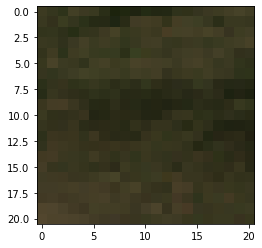

In [30]:
plot_image(dataset_sub[510004])

In [31]:
image

<xarray.Dataset>
Dimensions:                                   (band: 1, y: 918, x: 3268)
Coordinates:
  * x                                         (x) float64 -140.0 ... -104.4
  * y                                         (y) float64 49.99 49.98 ... 40.01
  * band                                      (band) int32 1
    spatial_ref                               int32 0
Data variables: (12/14)
    BRDF_Albedo_Band_Mandatory_Quality_Band1  (band, y, x) uint16 32767 ... 3...
    Nadir_Reflectance_Band3                   (band, y, x) int16 32767 ... 32767
    Nadir_Reflectance_Band4                   (band, y, x) int16 32767 ... 32767
    Nadir_Reflectance_Band5                   (band, y, x) int16 32767 ... 32767
    Nadir_Reflectance_Band6                   (band, y, x) int16 32767 ... 32767
    Nadir_Reflectance_Band7                   (band, y, x) int16 32767 ... 32767
    ...                                        ...
    BRDF_Albedo_Band_Mandatory_Quality_Band4  (band, y, x) uint16 32767 ... 3...
    BRDF_Albedo_Band_Mandatory_Quality_Band5  (band, y, x) uint16 32767 ... 3...
    BRDF_Albedo_Band_Mandatory_Quality_Band6  (band, y, x) uint16 32767 ... 3...
    BRDF_Albedo_Band_Mandatory_Quality_Band7  (band, y, x) uint16 32767 ... 3...
    Nadir_Reflectance_Band1                   (band, y, x) int16 32767 ... 32767
    Nadir_Reflectance_Band2                   (band, y, x) int16 32767 ... 32767
Attributes: (12/70)
    ALBEDOFILEID:                       6121997
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDINSTRUMENTSHORTNAME.2:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDPLATFORMSHORTNAME.2:      Aqua
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    ...                                 ...
    SOUTHBOUNDINGCOORDINATE:            39.9999999964079
    SPSOPARAMETERS:                     2015
    TileID:                             51009004
    VERSIONID:                          6
    VERTICALTILENUMBER:                 4
    WESTBOUNDINGCOORDINATE:             -140.015144391787